In [0]:
#pip install geopandas

If you want to run the code and geopandas are missing uncomment above line and install first then run the below command.

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from lightgbm import LGBMRegressor

In [0]:
data_train = pd.read_csv("train_set.csv")
data_test = pd.read_csv("test_set.csv")

In [92]:
data_train.shape, data_test.shape

((595848, 37), (10455, 37))

In [0]:
try:
    data = pd.concat([data_train, data_test], ignore_index=True, sort=False, verify_integrity=True)
except ValueError as e:
    print("ValueError:", e)

In [94]:
data.shape

(606303, 37)

In [95]:
data[data.duplicated(subset=None, keep='first')]    # Is there any duplicate ?

,id,yyear,week_of_year,advertiser_id,market,hotel_id,clicks,cost,bookings,top_pos,beat,meet,lose,impressions,city_id,stars,rating,distance_to_city_centre,poi_image,longitude,latitude,last_renovation,spa_hotel,country_hotel,convention_hotel,beach_front_hotel,luxury_hotel,city_hotel_centrally_located,health_resortrehab_hotel,club_club_hotel,airport_hotel,senior_hotel,eco_friendly_hotel,family_hotel,total_images,total_hq_images,advertiser_connections


In [96]:
data.head(10)

,id,yyear,week_of_year,advertiser_id,market,hotel_id,clicks,cost,bookings,top_pos,beat,meet,lose,impressions,city_id,stars,rating,distance_to_city_centre,poi_image,longitude,latitude,last_renovation,spa_hotel,country_hotel,convention_hotel,beach_front_hotel,luxury_hotel,city_hotel_centrally_located,health_resortrehab_hotel,club_club_hotel,airport_hotel,senior_hotel,eco_friendly_hotel,family_hotel,total_images,total_hq_images,advertiser_connections
0,201716IM512425060,2017,16,5124,IM,25060,2,1104,0.0,1,1.0,4388.0,988.0,5309,39332,3,1000.0,1570,0,-1.885049,52.470711,2012.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,105,41,269
1,20176IM135625060,2017,6,1356,IM,25060,34,33281,11.0,174,37.0,11634.0,1802.0,13455,39332,3,1000.0,1570,0,-1.885049,52.470711,2012.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,105,41,269
2,201728IM512425060,2017,28,5124,IM,25060,3,2001,0.0,0,24.0,3975.0,2719.0,6666,39332,3,1000.0,1570,0,-1.885049,52.470711,2012.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,105,41,269
3,201726IM135625060,2017,26,1356,IM,25060,218,282394,21.0,1467,55.0,5182.0,1256.0,6444,39332,3,1000.0,1570,0,-1.885049,52.470711,2012.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,105,41,269
4,201737IM107125060,2017,37,1071,IM,25060,5,4600,0.0,42,NaN,NaN,NaN,5428,39332,3,1000.0,1570,0,-1.885049,52.470711,2012.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,105,41,269
5,20178IM135625060,2017,8,1356,IM,25060,25,23506,7.0,258,3.0,6364.0,39.0,6406,39332,3,1000.0,1570,0,-1.885049,52.470711,2012.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,105,41,269
6,201748IM121825060,2017,48,1218,IM,25060,8,8441,0.0,10,8.0,3663.0,860.0,4494,39332,3,1000.0,1570,0,-1.885049,52.470711,2012.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,105,41,269
7,20185IM121825060,2018,5,1218,IM,25060,522,730227,60.0,6060,0.0,45.0,9370.0,9340,39332,3,1000.0,1570,0,-1.885049,52.470711,2012.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,105,41,269
8,201732IM508825060,2017,32,5088,IM,25060,1,460,0.0,0,9.0,29.0,3641.0,3350,39332,3,1000.0,1570,0,-1.885049,52.470711,2012.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,105,41,269
9,201720IM121825060,2017,20,1218,IM,25060,191,276782,63.0,2833,1.0,58.0,6631.0,6688,39332,3,1000.0,1570,0,-1.885049,52.470711,2012.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,105,41,269


In [97]:
data[:data_train.shape[0]]['cost'].mean()

63540.859821632366

In [98]:
data[:data_train.shape[0]]['yyear'].value_counts()  # Let's see the train data is of which year.

2017    534570
2018     61278
Name: yyear, dtype: int64

In [99]:
data['market'].value_counts()  # From the above table I could see only one type of 'market'. If that is the case we can safely ignore this column. 

IM    606303
Name: market, dtype: int64

**There is only one value in market type. SO we can safely drop this column.**

In [0]:
data = data.drop(['market'],axis=1)  # Dropping the market column

In [101]:
data.isna().sum()  # There are lots of NAN in the data. So let's find out how many NAN are there.

id                                   0
yyear                                0
week_of_year                         0
advertiser_id                        0
hotel_id                             0
clicks                               0
cost                                 0
bookings                         10455
top_pos                              0
beat                             52369
meet                             52369
lose                             52369
impressions                          0
city_id                              0
stars                                0
rating                           54981
distance_to_city_centre              0
poi_image                            0
longitude                            0
latitude                             0
last_renovation                 362190
spa_hotel                       493066
country_hotel                   562407
convention_hotel                462395
beach_front_hotel               548164
luxury_hotel             

**Lot of NAN is there in our data. Let's quickly check how these columns are correlated with the booking column and with that we can get some idea which column are strongly related and which are not. And maybe based on that we can think of dropping NAN from the data.**

In [0]:
cor = data[:data_train.shape[0]].corr().style.background_gradient(cmap = 'coolwarm')

In [103]:
cor

/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


**So it is not showing me anything which are strongly related. So now if we check the values in 'bookings' column we can see some positive and negative values. And out of those values 'clicks', 'cost', and 'top_pos' have strong relation with the 'bookings' which is kind of obvious if we think it in general perspective.
<br>
<br>
Here i can see 'poi_image' ahs all 'nan' values. So we might want to drop it.**

In [104]:
data['poi_image'].value_counts()

0    606303
Name: poi_image, dtype: int64

In [0]:
# Because there was only type of value in 'poi_image' as we have suspected from corr table above. Let's drop it.
data = data.drop(['poi_image'],axis = 1)

**'Corr' table above was not a great help for now. So let's analyze column by column.**

**The week of the year can tell me in which week the bookings are high and what is the cost. With the week of the year we will also get the idea in which month the hotels are high in demand**

**So as we know we have data from 2017 and 2018. So let's group them based on the year.**

In [0]:
group_year_wise = data[:data_train.shape[0]].groupby('yyear')

In [0]:
group_2017 = group_year_wise.get_group(2017)
group_2018 = group_year_wise.get_group(2018)

In [108]:
group_2017.head()

,id,yyear,week_of_year,advertiser_id,hotel_id,clicks,cost,bookings,top_pos,beat,meet,lose,impressions,city_id,stars,rating,distance_to_city_centre,longitude,latitude,last_renovation,spa_hotel,country_hotel,convention_hotel,beach_front_hotel,luxury_hotel,city_hotel_centrally_located,health_resortrehab_hotel,club_club_hotel,airport_hotel,senior_hotel,eco_friendly_hotel,family_hotel,total_images,total_hq_images,advertiser_connections
0,201716IM512425060,2017,16,5124,25060,2,1104,0.0,1,1.0,4388.0,988.0,5309,39332,3,1000.0,1570,-1.885049,52.470711,2012.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,105,41,269
1,20176IM135625060,2017,6,1356,25060,34,33281,11.0,174,37.0,11634.0,1802.0,13455,39332,3,1000.0,1570,-1.885049,52.470711,2012.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,105,41,269
2,201728IM512425060,2017,28,5124,25060,3,2001,0.0,0,24.0,3975.0,2719.0,6666,39332,3,1000.0,1570,-1.885049,52.470711,2012.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,105,41,269
3,201726IM135625060,2017,26,1356,25060,218,282394,21.0,1467,55.0,5182.0,1256.0,6444,39332,3,1000.0,1570,-1.885049,52.470711,2012.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,105,41,269
4,201737IM107125060,2017,37,1071,25060,5,4600,0.0,42,NaN,NaN,NaN,5428,39332,3,1000.0,1570,-1.885049,52.470711,2012.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,105,41,269


Text(0.5, 1.0, 'For Year 2017')

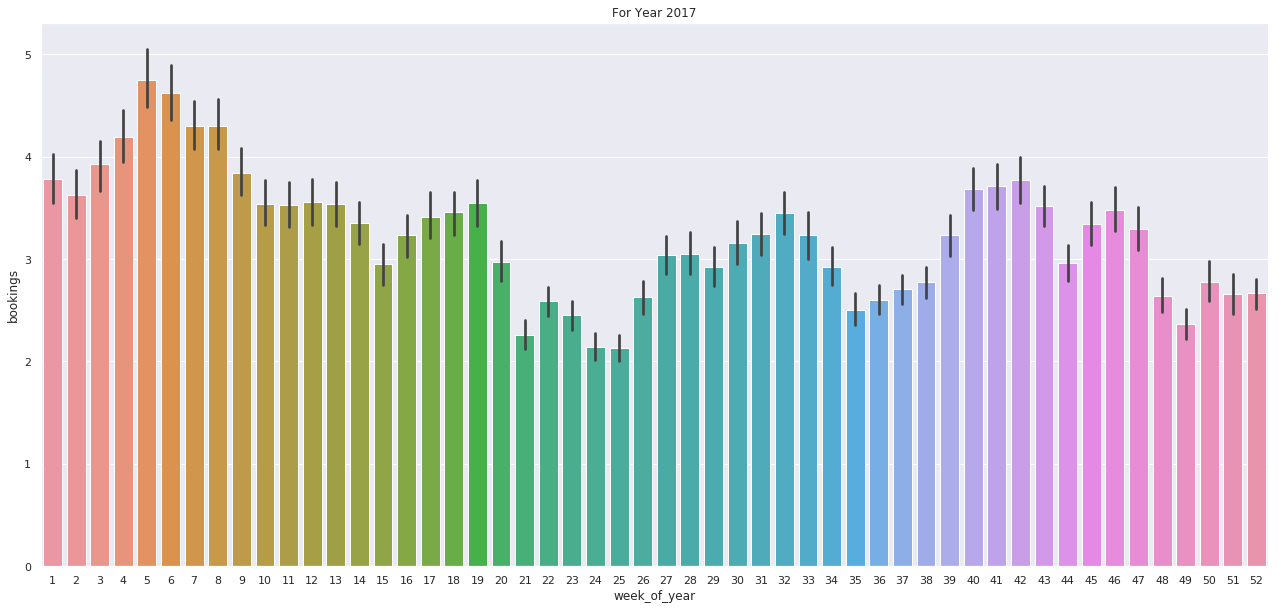

In [109]:
fig, ax = plt.subplots(figsize=[22,10])
sns.barplot(x="week_of_year", y = "bookings", data = group_2017, ax = ax)
plt.title('For Year 2017')

Text(0.5, 1.0, 'For Year 2018')

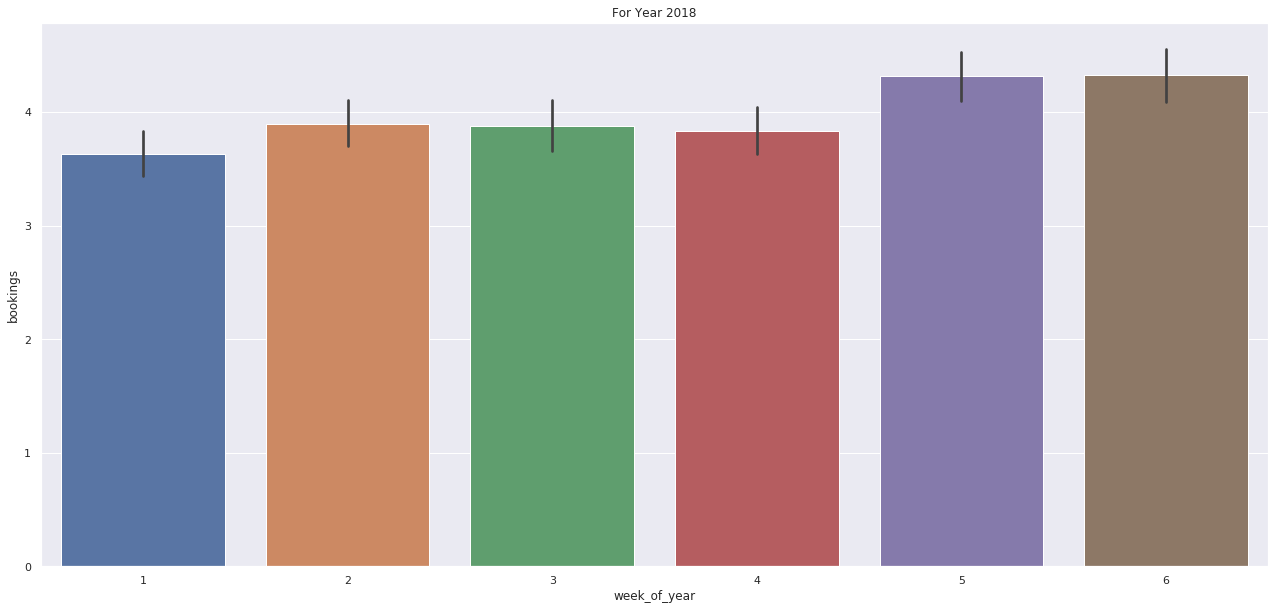

In [110]:
fig, ax = plt.subplots(figsize=[22,10])
sns.barplot(x="week_of_year", y = "bookings", data = group_2018, ax = ax)
plt.title('For Year 2018')

**Week 5 and 6 have hightest bookings, in both the years. Which is the end of January and start of February. And in 2017 there was again a rise in week 16 to 19 which is around mid April to mid May. And again in July aand August (week 30 - 32) and then week 40 - 43 (whole October). And during the time of christmas and New Year the bookings are comparitively low** 

**Now let's see how the costs are behaving.**

Text(0.5, 1.0, 'For Year 2017')

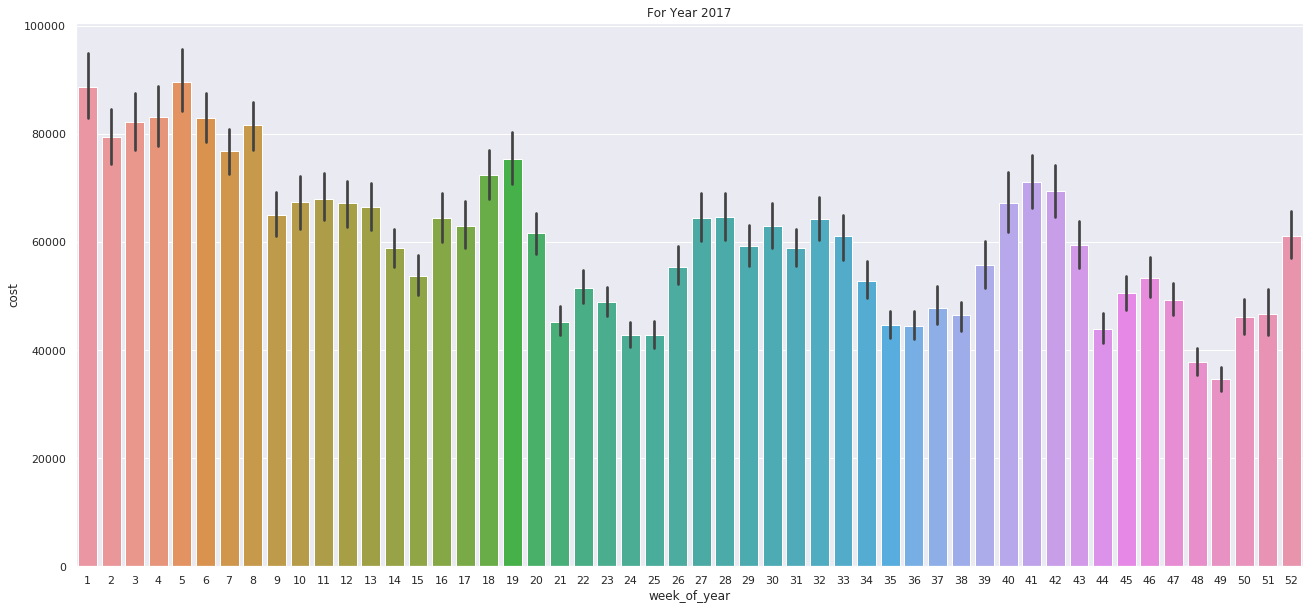

In [111]:
fig, ax = plt.subplots(figsize=[22,10])
sns.barplot(x="week_of_year", y = "cost", data = group_2017, ax = ax)
plt.title('For Year 2017')

**So the cost of Week 1 and week 5 are hightest but cost of week 6 is low. So in New Year costs are high which is obvious. So we can see the trend here, Costs are high for those months in which there was more number of bookings.** 

Text(0.5, 1.0, 'For Year 2018')

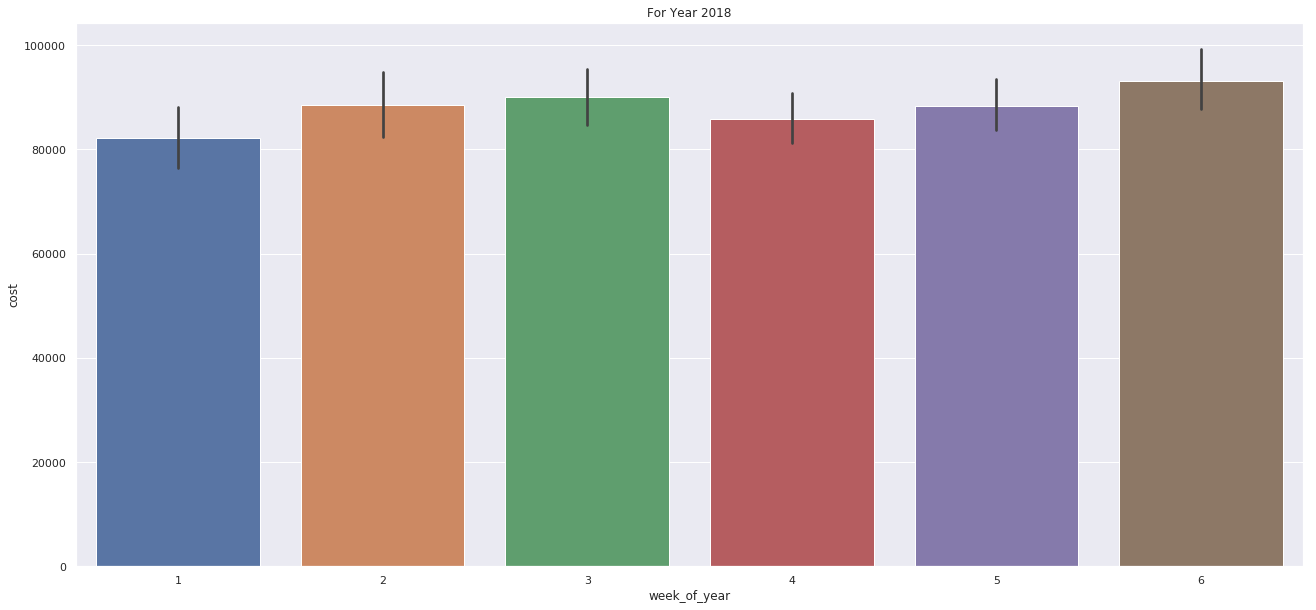

In [112]:
fig, ax = plt.subplots(figsize=[22,10])
sns.barplot(x="week_of_year", y = "cost", data = group_2018, ax = ax)
plt.title('For Year 2018')

**Now let's see how the books are changing based on clicks.**

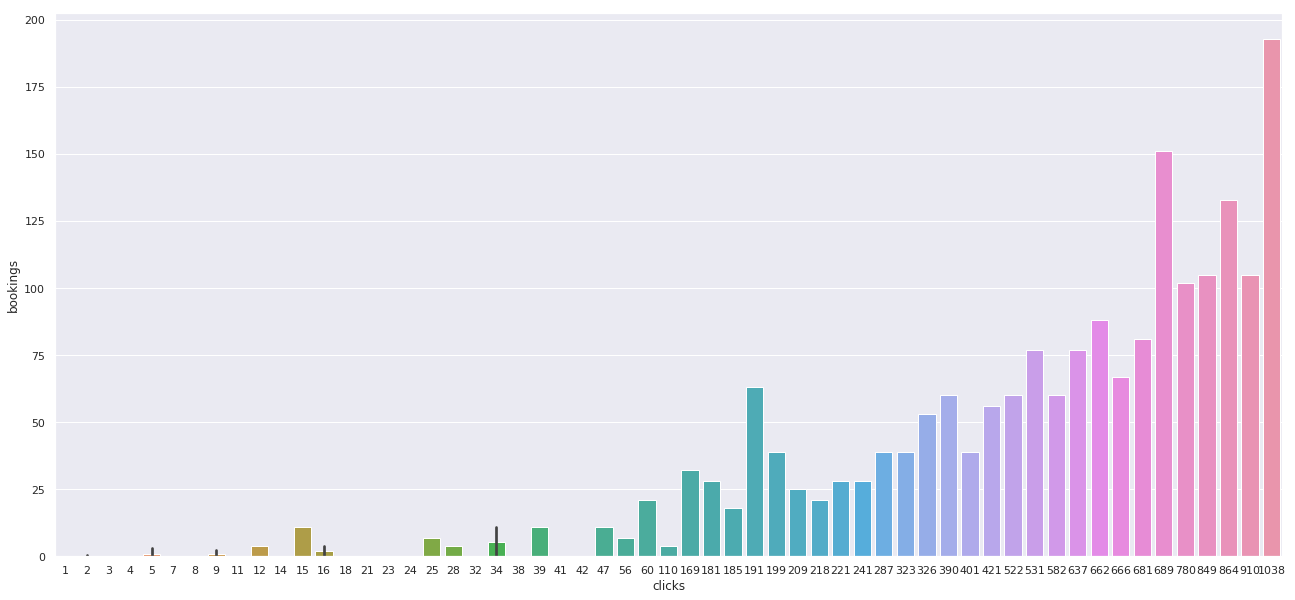

In [113]:
fig, ax = plt.subplots(figsize=[22,10])
sns.barplot(x=data[:data_train.shape[0]]['clicks'][:100], y = data[:data_train.shape[0]]['bookings'][:100], ax = ax)

**So, more clicks will increase the chances of booking.**

**Which hotel_id has more bookings ?**

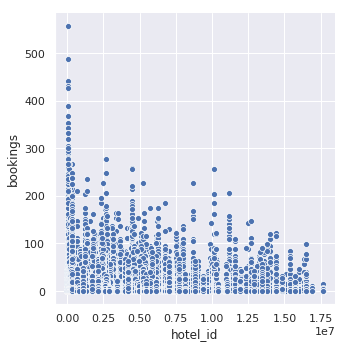

In [114]:
sns.set(style="darkgrid")
sns.relplot(x="hotel_id", y="bookings", data=data[:data_train.shape[0]])

**Majority of hotels has bookings under 200. But some of them have comparitevly very high bookings. Like more than 500 maybe those are outliers.**

In [115]:
data[:data_train.shape[0]].loc[data[:data_train.shape[0]]['bookings'] >= 500]

,id,yyear,week_of_year,advertiser_id,hotel_id,clicks,cost,bookings,top_pos,beat,meet,lose,impressions,city_id,stars,rating,distance_to_city_centre,longitude,latitude,last_renovation,spa_hotel,country_hotel,convention_hotel,beach_front_hotel,luxury_hotel,city_hotel_centrally_located,health_resortrehab_hotel,club_club_hotel,airport_hotel,senior_hotel,eco_friendly_hotel,family_hotel,total_images,total_hq_images,advertiser_connections
197225,201710IM121825188,2017,10,1218,25188,4936,7990522,557.0,34728,52.0,14571.0,22487.0,36877,35284,3,0.0,270,-2.237344,53.479019,1988.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,56,34,288
197902,20179IM121825188,2017,9,1218,25188,5416,9291080,557.0,37180,53.0,17063.0,21907.0,38976,35284,3,0.0,270,-2.237344,53.479019,1988.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,56,34,288


**So there is only one hotel (same hotel_id)
<br>
Ok so I think this is the only hotel in this area (from latitude - longitude). So whether its a 3 star, luxurious etc. doesn't makes any sense because people doesn't have any option of booking any other hotel.
<br>
So let's consider this outlier for now**

In [116]:
data_400 = data[:data_train.shape[0]].loc[data[:data_train.shape[0]]['bookings'] >= 400]     
data_400 = data_400.loc[data_400['bookings'] <=500]
data_400

,id,yyear,week_of_year,advertiser_id,hotel_id,clicks,cost,bookings,top_pos,beat,meet,lose,impressions,city_id,stars,rating,distance_to_city_centre,longitude,latitude,last_renovation,spa_hotel,country_hotel,convention_hotel,beach_front_hotel,luxury_hotel,city_hotel_centrally_located,health_resortrehab_hotel,club_club_hotel,airport_hotel,senior_hotel,eco_friendly_hotel,family_hotel,total_images,total_hq_images,advertiser_connections
197353,20178IM121825188,2017,8,1218,25188,4187,6977487,441.0,33946,87.0,13196.0,24074.0,37188,35284,3,0.0,270,-2.237344,53.479019,1988.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,56,34,288
197396,201712IM121825188,2017,12,1218,25188,3958,6892985,431.0,34305,270.0,16335.0,20208.0,36781,35284,3,0.0,270,-2.237344,53.479019,1988.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,56,34,288
197539,201730IM121825188,2017,30,1218,25188,4144,8315995,427.0,27254,6.0,3781.0,29918.0,33430,35284,3,0.0,270,-2.237344,53.479019,1988.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,56,34,288
197639,201711IM121825188,2017,11,1218,25188,4776,7610079,487.0,31652,293.0,15224.0,18008.0,33345,35284,3,0.0,270,-2.237344,53.479019,1988.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,56,34,288


**Again the same hotel in that location. So this is confirming out doubt that if it's the only hotel in that location. So obviously the cost will be high. And its an average hotel because no extra facilities.
SO in order to make good predictions I think removing these values would be good.**

In [117]:
data_300 = data[:data_train.shape[0]].loc[data[:data_train.shape[0]]['bookings'] >= 300]     
data_300 = data_300.loc[data_300['bookings'] <=400]
data_300

,id,yyear,week_of_year,advertiser_id,hotel_id,clicks,cost,bookings,top_pos,beat,meet,lose,impressions,city_id,stars,rating,distance_to_city_centre,longitude,latitude,last_renovation,spa_hotel,country_hotel,convention_hotel,beach_front_hotel,luxury_hotel,city_hotel_centrally_located,health_resortrehab_hotel,club_club_hotel,airport_hotel,senior_hotel,eco_friendly_hotel,family_hotel,total_images,total_hq_images,advertiser_connections
4040,201733IM121825062,2017,33,1218,25062,1921,3177818,319.0,18944,0.0,891.0,20271.0,21157,39332,3,0.0,411,-1.897074,52.479103,2006.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,65,52,292
66772,20183IM121825044,2018,3,1218,25044,3206,7249899,354.0,25323,11.0,2068.0,26175.0,28251,39332,4,0.0,664,-1.911700,52.476700,2012.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,55,31,301
197333,20185IM121825188,2018,5,1218,25188,2381,4019365,301.0,24153,2.0,755.0,33750.0,33761,35284,3,0.0,270,-2.237344,53.479019,1988.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,56,34,288
197365,20172IM121825188,2017,2,1218,25188,2349,3922788,305.0,26979,153.0,6334.0,24971.0,31313,35284,3,0.0,270,-2.237344,53.479019,1988.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,56,34,288
197470,201746IM249025188,2017,46,2490,25188,1760,2583958,343.0,13930,4486.0,1042.0,21869.0,19691,35284,3,0.0,270,-2.237344,53.479019,1988.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,56,34,288
197636,201745IM249025188,2017,45,2490,25188,2135,3161304,333.0,16078,2645.0,470.0,23477.0,21225,35284,3,0.0,270,-2.237344,53.479019,1988.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,56,34,288
197882,201727IM121825188,2017,27,1218,25188,2769,5412061,301.0,18899,1.0,4980.0,23470.0,28396,35284,3,0.0,270,-2.237344,53.479019,1988.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,56,34,288
197885,201733IM121825188,2017,33,1218,25188,4068,6729708,389.0,28253,8.0,3552.0,30552.0,34021,35284,3,0.0,270,-2.237344,53.479019,1988.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,56,34,288
197900,20175IM121825188,2017,5,1218,25188,3395,5218677,368.0,37697,614.0,14034.0,27361.0,41169,35284,3,0.0,270,-2.237344,53.479019,1988.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,56,34,288
222600,201713IM121825188,2017,13,1218,25188,3855,6892433,333.0,31576,47.0,8346.0,25962.0,34287,35284,3,0.0,270,-2.237344,53.479019,1988.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,56,34,288


**Again same hotel from above. Top two hotels are different and they are situated at different locations in the same city. Hotel_ID  25044 has more bookigs, because of good impression, and latest renovation, starts are also high. Though the distace from city_centre is little far from hotel_id  25062  but that seems to be OK.**

In [118]:
data_200 = data[:data_train.shape[0]].loc[data[:data_train.shape[0]]['bookings'] >= 200]     
data_200 = data_200.loc[data_200['bookings'] <=300]
data_200

,id,yyear,week_of_year,advertiser_id,hotel_id,clicks,cost,bookings,top_pos,beat,meet,lose,impressions,city_id,stars,rating,distance_to_city_centre,longitude,latitude,last_renovation,spa_hotel,country_hotel,convention_hotel,beach_front_hotel,luxury_hotel,city_hotel_centrally_located,health_resortrehab_hotel,club_club_hotel,airport_hotel,senior_hotel,eco_friendly_hotel,family_hotel,total_images,total_hq_images,advertiser_connections
13393,201733IM121811199496,2017,33,1218,11199496,2938,4476950,207.0,31750,313.0,28140.0,3416.0,31869,40278,3,NaN,695,-1.073269,53.953800,2016.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,47,46,78
17761,201741IM121894202,2017,41,1218,94202,2354,5384116,228.0,37188,13.0,11986.0,25774.0,37773,34798,4,0.0,1806,-0.122177,51.491478,2016.0,NaN,NaN,1.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,1.0,77,54,306
39982,20184IM249093962,2018,4,2490,93962,1808,2582210,221.0,9726,1371.0,618.0,8514.0,10409,68258,3,0.0,786,-4.223536,57.479336,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,140,68,289
44436,201731IM121825062,2017,31,1218,25062,1606,2667655,252.0,19392,0.0,986.0,20317.0,20746,39332,3,0.0,411,-1.897074,52.479103,2006.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,65,52,292
44500,201750IM121825062,2017,50,1218,25062,610,1262355,203.0,6493,0.0,379.0,10777.0,10967,39332,3,0.0,411,-1.897074,52.479103,2006.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,65,52,292
44529,201730IM121825062,2017,30,1218,25062,1968,3537262,252.0,20130,4.0,1922.0,18575.0,20501,39332,3,0.0,411,-1.897074,52.479103,2006.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,65,52,292
44545,201732IM121825062,2017,32,1218,25062,1837,3009918,287.0,16699,0.0,971.0,19080.0,19615,39332,3,0.0,411,-1.897074,52.479103,2006.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,65,52,292
44728,20178IM121825062,2017,8,1218,25062,1040,1401712,224.0,15919,0.0,9107.0,8755.0,17555,39332,3,0.0,411,-1.897074,52.479103,2006.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,65,52,292
44740,20183IM121825062,2018,3,1218,25062,982,1635392,221.0,12627,3.0,2757.0,13176.0,15719,39332,3,0.0,411,-1.897074,52.479103,2006.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,65,52,292
59823,201710IM1218304064,2017,10,1218,304064,1467,1654114,266.0,13512,85.0,13389.0,832.0,14274,39332,2,0.0,910,-1.900587,52.471523,2014.0,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,59,41,144


**Let's consider city_id 39332. So I can't make any strong comments just by looking at the data values because all the values are mixed. Sometimes latest renovated has high bookings and sometimes not. sometimes highly rated hotel has more bookings and sometimes least rated.And some has spa facility and doesn't have it.  So its difficult to make any judgement.**

In [0]:
data_100 = data[:data_train.shape[0]].loc[data[:data_train.shape[0]]['bookings'] >= 0]     
data_100 = data_100.loc[data_100['bookings'] <=300]

**Let's check the correlation again.**

In [120]:
cor = data[:data_train.shape[0]].corr().style.background_gradient(cmap = 'coolwarm')
cor

/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


**Booking is highly dependent on clicks,cost and top_pos. And advertiser_id and hotel_id also have some positive values.**

In [121]:
cor_ = data.corr()
cor_target = abs(cor_["hotel_id"])

#checking highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

hotel_id                  1.000000
advertiser_connections    0.655813
Name: hotel_id, dtype: float64

In [122]:
cor_target = abs(cor_["advertiser_id"])

#checking highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

advertiser_id    1.0
Name: advertiser_id, dtype: float64

**How useful are the stars?**

In [123]:
data[:data_train.shape[0]][['cost','stars','bookings','advertiser_id']].corr()

,cost,stars,bookings,advertiser_id
cost,1.000000,0.011656,0.722395,-0.167894
stars,0.011656,1.000000,-0.060407,0.090164
bookings,0.722395,-0.060407,1.000000,-0.187115
advertiser_id,-0.167894,0.090164,-0.187115,1.000000


**Stars is useful for advertisers as compared to booking.**

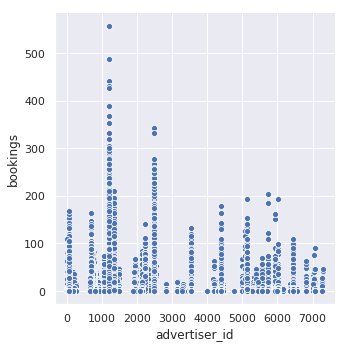

In [124]:
sns.relplot(x="advertiser_id", y="bookings", data=data[:data_train.shape[0]])

In [125]:
# We know about this advertiser_id from above analysis.

data[:data_train.shape[0]].loc[data[:data_train.shape[0]]['advertiser_id'] == 1218]

,id,yyear,week_of_year,advertiser_id,hotel_id,clicks,cost,bookings,top_pos,beat,meet,lose,impressions,city_id,stars,rating,distance_to_city_centre,longitude,latitude,last_renovation,spa_hotel,country_hotel,convention_hotel,beach_front_hotel,luxury_hotel,city_hotel_centrally_located,health_resortrehab_hotel,club_club_hotel,airport_hotel,senior_hotel,eco_friendly_hotel,family_hotel,total_images,total_hq_images,advertiser_connections
6,201748IM121825060,2017,48,1218,25060,8,8441,0.0,10,8.0,3663.0,860.0,4494,39332,3,1000.0,1570,-1.885049,52.470711,2012.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,105,41,269
7,20185IM121825060,2018,5,1218,25060,522,730227,60.0,6060,0.0,45.0,9370.0,9340,39332,3,1000.0,1570,-1.885049,52.470711,2012.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,105,41,269
9,201720IM121825060,2017,20,1218,25060,191,276782,63.0,2833,1.0,58.0,6631.0,6688,39332,3,1000.0,1570,-1.885049,52.470711,2012.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,105,41,269
11,201726IM121825060,2017,26,1218,25060,531,715323,77.0,5215,24.0,6529.0,1284.0,7821,39332,3,1000.0,1570,-1.885049,52.470711,2012.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,105,41,269
13,201724IM121825060,2017,24,1218,25060,241,308154,28.0,2484,8.0,5032.0,1074.0,6097,39332,3,1000.0,1570,-1.885049,52.470711,2012.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,105,41,269
15,201752IM121825060,2017,52,1218,25060,199,308729,39.0,2566,0.0,2540.0,1782.0,4315,39332,3,1000.0,1570,-1.885049,52.470711,2012.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,105,41,269
17,20178IM121825060,2017,8,1218,25060,421,489969,56.0,6258,1.0,6242.0,36.0,6279,39332,3,1000.0,1570,-1.885049,52.470711,2012.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,105,41,269
18,201714IM121825060,2017,14,1218,25060,390,431641,60.0,3757,2.0,5229.0,221.0,5445,39332,3,1000.0,1570,-1.885049,52.470711,2012.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,105,41,269
20,201738IM121825060,2017,38,1218,25060,401,502044,39.0,4835,6.0,8710.0,1581.0,10234,39332,3,1000.0,1570,-1.885049,52.470711,2012.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,105,41,269
22,201742IM121825060,2017,42,1218,25060,864,1232662,133.0,8891,7.0,10531.0,1291.0,11798,39332,3,1000.0,1570,-1.885049,52.470711,2012.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,105,41,269


**So if we see below hotel (hotel_id 14828828) they have lot of 0 bookings. Inspite of low cost they have less bookings. Doesn't have any good impression and they have only 1 image. But I think impression has nothing to do with bookings because for hotel_id == 25060 impressions are good but 0 bookings. Clicks are very less which can affect the bokings. So let's drop Impressions.
<br>
Let's analyse the data based on geolocation.**

In [0]:
df = data[:data_train.shape[0]]
gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.longitude, df.latitude))

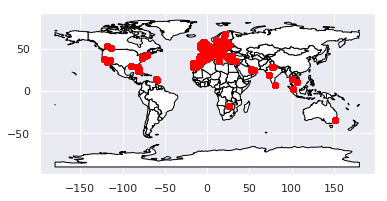

In [127]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax = world.plot(
    color='white', edgecolor='black')

# We can now plot our GeoDataFrame.
gdf.plot(ax=ax, color='red')

plt.show()

**SO it seems like there are some cities in which there is only one hotel.**

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


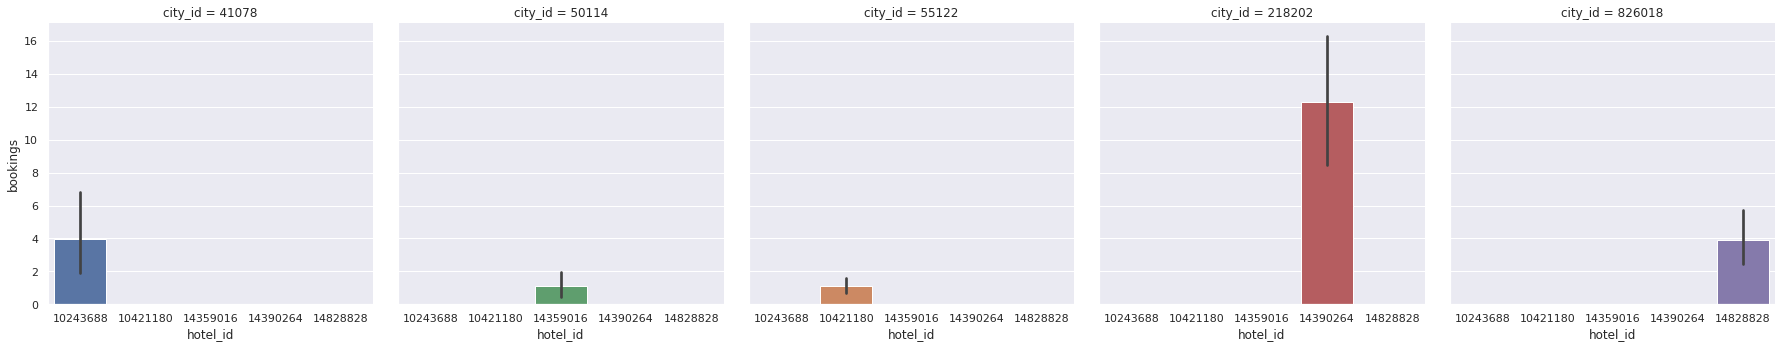

In [128]:
sns.factorplot("hotel_id", "bookings", col="city_id", data=df[-500:], kind = "bar")   # SHowing few of them

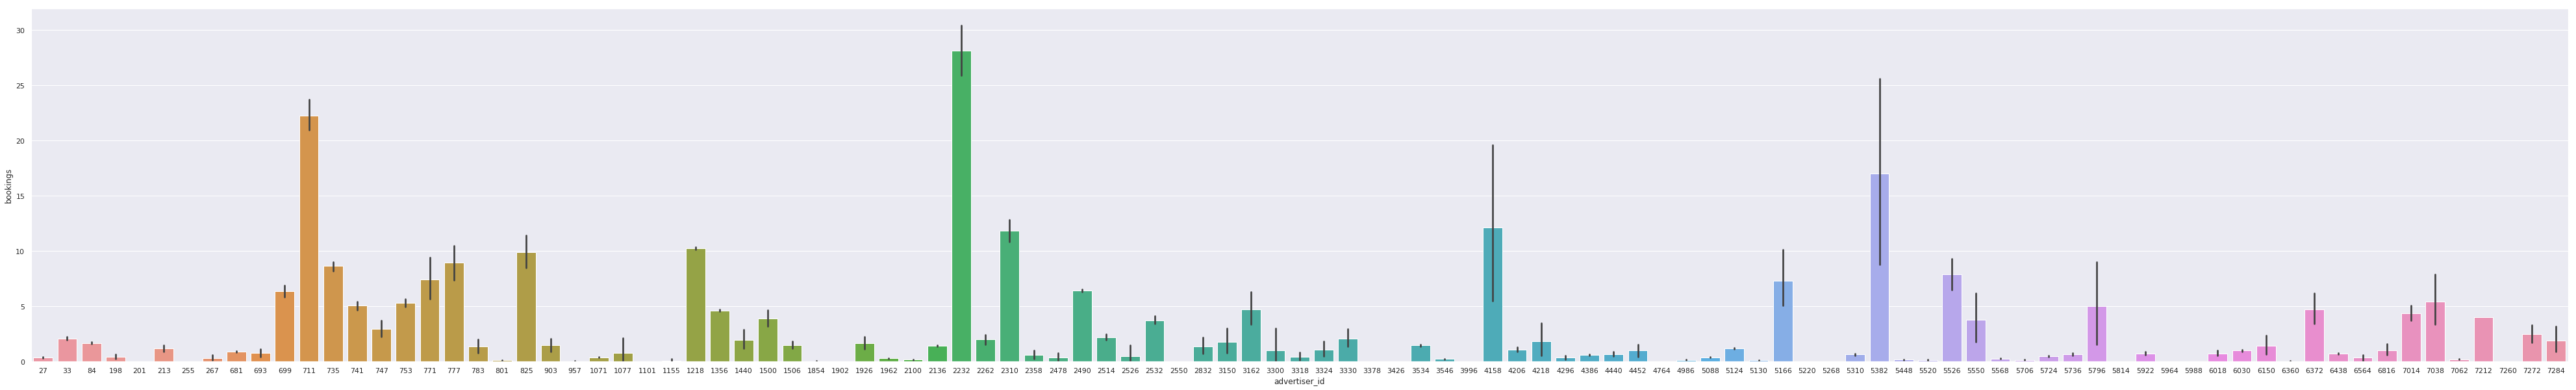

In [129]:
fig, ax = plt.subplots(figsize=[70,10])
sns.barplot(x=data[:data_train.shape[0]]['advertiser_id'], y = data[:data_train.shape[0]]['bookings'], ax = ax)


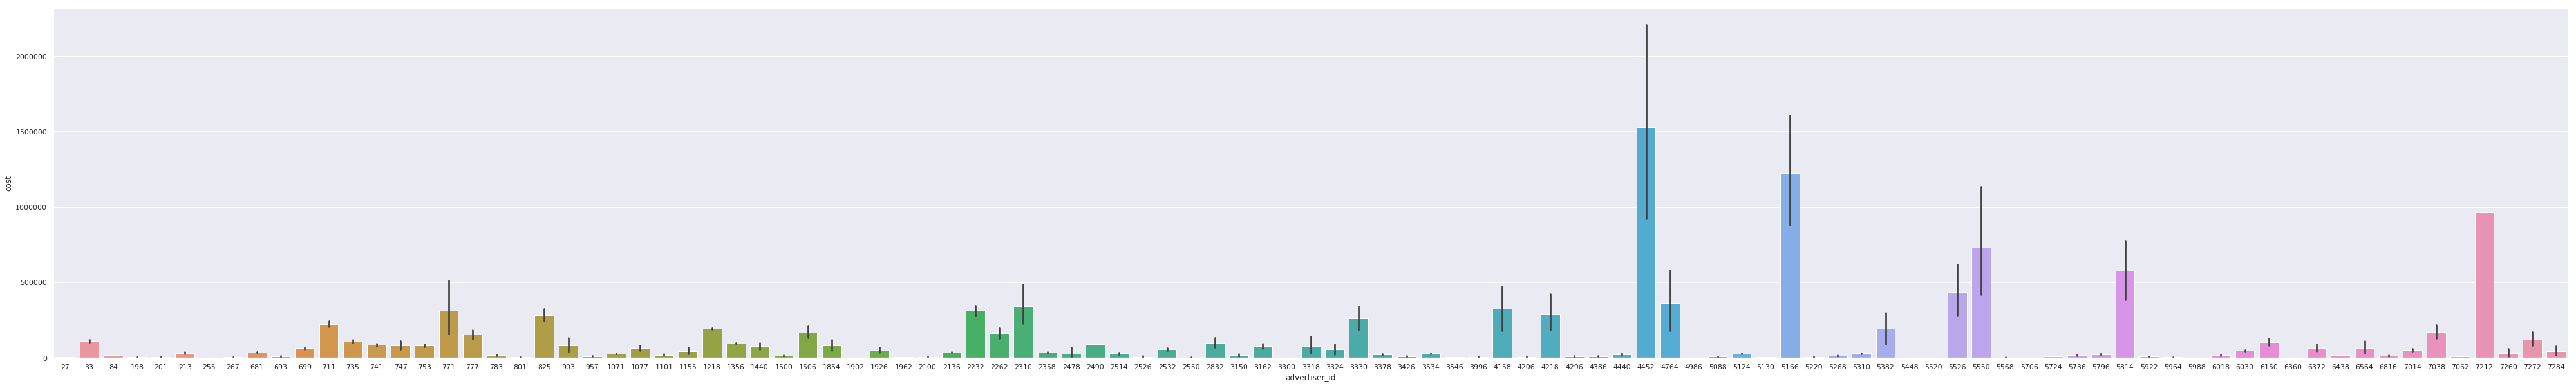

In [130]:
fig, ax = plt.subplots(figsize=[70,10])
sns.barplot(x=data[:data_train.shape[0]]['advertiser_id'], y = data[:data_train.shape[0]]['cost'], ax = ax)

**From the above chart we can see that the advertisers that have more bookings have kept the price low.**

In [131]:
data[:data_train.shape[0]].loc[data[:data_train.shape[0]]['advertiser_id'] == 4452][:10]   #High cost, low booking

,id,yyear,week_of_year,advertiser_id,hotel_id,clicks,cost,bookings,top_pos,beat,meet,lose,impressions,city_id,stars,rating,distance_to_city_centre,longitude,latitude,last_renovation,spa_hotel,country_hotel,convention_hotel,beach_front_hotel,luxury_hotel,city_hotel_centrally_located,health_resortrehab_hotel,club_club_hotel,airport_hotel,senior_hotel,eco_friendly_hotel,family_hotel,total_images,total_hq_images,advertiser_connections
548191,201731IM44524146104,2017,31,4452,4146104,198,246491,0.0,2882,2048.0,320.0,5550.0,5351,27044,4,NaN,4879,-16.731949,28.076687,NaN,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,96,83,219
548192,201747IM44524146104,2017,47,4452,4146104,23,22655,4.0,207,117.0,16.0,2531.0,2029,27044,4,NaN,4879,-16.731949,28.076687,NaN,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,96,83,219
548194,201743IM44524146104,2017,43,4452,4146104,122,169947,0.0,2051,940.0,103.0,3448.0,3523,27044,4,NaN,4879,-16.731949,28.076687,NaN,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,96,83,219
548195,201751IM44524146104,2017,51,4452,4146104,271,735563,0.0,2785,46.0,1.0,5037.0,3961,27044,4,NaN,4879,-16.731949,28.076687,NaN,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,96,83,219
548233,201735IM44524146104,2017,35,4452,4146104,77,76452,0.0,1105,3354.0,287.0,8636.0,3957,27044,4,NaN,4879,-16.731949,28.076687,NaN,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,96,83,219
548241,201745IM44524146104,2017,45,4452,4146104,38,27646,0.0,264,249.0,3.0,2312.0,2452,27044,4,NaN,4879,-16.731949,28.076687,NaN,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,96,83,219
548244,201741IM44524146104,2017,41,4452,4146104,806,1997941,0.0,6332,1434.0,443.0,10118.0,9493,27044,4,NaN,4879,-16.731949,28.076687,NaN,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,96,83,219
548273,20182IM44524146104,2018,2,4452,4146104,1054,2719888,4.0,10565,538.0,144.0,21136.0,14330,27044,4,NaN,4879,-16.731949,28.076687,NaN,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,96,83,219
548339,201733IM44524146104,2017,33,4452,4146104,793,1154439,4.0,7993,8655.0,402.0,2083.0,9014,27044,4,NaN,4879,-16.731949,28.076687,NaN,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,96,83,219
548342,201749IM44524146104,2017,49,4452,4146104,53,101660,0.0,912,70.0,8.0,2591.0,2603,27044,4,NaN,4879,-16.731949,28.076687,NaN,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,96,83,219


**Now if we compare these two results, we will find that the cost of the above advertiser was high because its spa_hotel, convention_hotel, beach_front_hotel and a family hotel. All these facilities increases the price and hence only few people can afford this.**

**So in order to determine number of bookings these columns can play a major role.**
<br>
**All these facilities itself says that hotel is luxurious.**

**And we can say that images and advertiser_connections  are not playing a major role in bookings because expensive hotels are having more images and may have more connections but the bookings are still less.**

**The Column which is not making any sense to me is 'senior_hotel'. Let's see how many real values do we have.**

In [132]:
data['senior_hotel'].value_counts()

1.0    4338
0.0     759
Name: senior_hotel, dtype: int64

**The values are extremely low. It's better to get rid of this column.**

In [0]:
data = data.drop(['senior_hotel'],axis=1)

**Let's see the % values of NaN. That way it will be easy to drop columns in which there are lot of NaN.**

In [134]:
((data.isnull() | data.isna()).sum() * 100 / data.index.size).round(2)

id                               0.00
yyear                            0.00
week_of_year                     0.00
advertiser_id                    0.00
hotel_id                         0.00
clicks                           0.00
cost                             0.00
bookings                         1.72
top_pos                          0.00
beat                             8.64
meet                             8.64
lose                             8.64
impressions                      0.00
city_id                          0.00
stars                            0.00
rating                           9.07
distance_to_city_centre          0.00
longitude                        0.00
latitude                         0.00
last_renovation                 59.74
spa_hotel                       81.32
country_hotel                   92.76
convention_hotel                76.26
beach_front_hotel               90.41
luxury_hotel                    92.17
city_hotel_centrally_located    28.90
health_resor

**So from above we can drop all those columns in which more than 50% values are NaN because it doesn't make sense to fill those columns with mean, median, or mode values because we don't have enough data in these column.**

In [0]:
data = data.drop(['last_renovation','country_hotel','health_resortrehab_hotel','club_club_hotel','airport_hotel','eco_friendly_hotel'],axis=1)

In [0]:
data = data.drop(['impressions'],axis=1)   # Dropped impressions as analyzed before.

In [137]:
((data.isnull() | data.isna()).sum() * 100 / data.index.size).round(2)

id                               0.00
yyear                            0.00
week_of_year                     0.00
advertiser_id                    0.00
hotel_id                         0.00
clicks                           0.00
cost                             0.00
bookings                         1.72
top_pos                          0.00
beat                             8.64
meet                             8.64
lose                             8.64
city_id                          0.00
stars                            0.00
rating                           9.07
distance_to_city_centre          0.00
longitude                        0.00
latitude                         0.00
spa_hotel                       81.32
convention_hotel                76.26
beach_front_hotel               90.41
luxury_hotel                    92.17
city_hotel_centrally_located    28.90
family_hotel                    61.14
total_images                     0.00
total_hq_images                  0.00
advertiser_c

In [0]:
data['beat'].fillna(data['beat'].mean(),inplace=True)
data['meet'].fillna(data['meet'].mean(),inplace=True)
data['lose'].fillna(data['lose'].mean(),inplace=True)

In [0]:
data['rating'].fillna(data['rating'].mode()[0],inplace=True)

In [0]:
data['city_hotel_centrally_located'].fillna(data['city_hotel_centrally_located'].mode()[0],inplace=True)

In [146]:
data[['luxury_hotel','beach_front_hotel','convention_hotel','spa_hotel','family_hotel','bookings','cost','advertiser_id']].corr()

,luxury_hotel,beach_front_hotel,convention_hotel,spa_hotel,family_hotel,bookings,cost,advertiser_id
luxury_hotel,1.000000,NaN,0.484319,0.444442,NaN,-0.024656,-0.009806,0.036919
beach_front_hotel,NaN,1.000000,-0.049361,-0.022821,-0.040277,-0.037380,-0.030897,0.003480
convention_hotel,0.484319,-0.049361,1.000000,0.048189,-0.031677,0.011844,0.003356,0.006035
spa_hotel,0.444442,-0.022821,0.048189,1.000000,-0.029712,-0.043096,-0.022847,0.005212
family_hotel,NaN,-0.040277,-0.031677,-0.029712,1.000000,0.019022,0.014414,0.007517
bookings,-0.024656,-0.037380,0.011844,-0.043096,0.019022,1.000000,0.722395,-0.187115
cost,-0.009806,-0.030897,0.003356,-0.022847,0.014414,0.722395,1.000000,-0.168496
advertiser_id,0.036919,0.003480,0.006035,0.005212,0.007517,-0.187115,-0.168496,1.000000


**Because these columns is showing some positive relation with advertiser_id. Lets not drop them. I am replacing all NaN with O's.** 


In [0]:
data['beach_front_hotel'].fillna(0, inplace=True)
data['luxury_hotel'].fillna(0, inplace=True)
data['convention_hotel'].fillna(0, inplace=True)
data['spa_hotel'].fillna(0, inplace=True)
data['family_hotel'].fillna(0, inplace=True)

In [148]:
((data.isnull() | data.isna()).sum() * 100 / data.index.size).round(2)  #Now we don't have any null values. Except from test data booking column.

id                              0.00
yyear                           0.00
week_of_year                    0.00
advertiser_id                   0.00
hotel_id                        0.00
clicks                          0.00
cost                            0.00
bookings                        1.72
top_pos                         0.00
beat                            0.00
meet                            0.00
lose                            0.00
city_id                         0.00
stars                           0.00
rating                          0.00
distance_to_city_centre         0.00
longitude                       0.00
latitude                        0.00
spa_hotel                       0.00
convention_hotel                0.00
beach_front_hotel               0.00
luxury_hotel                    0.00
city_hotel_centrally_located    0.00
family_hotel                    0.00
total_images                    0.00
total_hq_images                 0.00
advertiser_connections          0.00
d

**I didn't find anything interesting going on with the images of the hotels so I am just going to leave it like that.
And advertiser connections are useful for advertisers but didn't find any real impact with the bookings, so I am leaving it like that.**

**Let's train our model.**

In [0]:
data_tr = data[:data_train.shape[0]]
data_ts = data[data_train.shape[0]:]

In [0]:
# Here I are removing some of the outliers that we saw in the beginning.

data_ = data_tr.loc[data_tr['bookings'] >= 0]     
data_ = data_.loc[data_['bookings'] <=500]

In [0]:
train_data = data_.drop(['id'], axis = 1)

In [161]:
test_data = data_ts

print(train_data.shape, test_data.shape)  # Test data has 27 columns because we have not dropped ID yet.

(595846, 26) (10455, 27)


In [162]:
Y = train_data['bookings'].values
X = train_data.drop(['bookings'],axis=1)

X_train, X_val, Y_train, Y_val = train_test_split(X,Y,test_size=0.20,random_state=22)

print(X_train.shape, X_val.shape, Y_train.shape, Y_val.shape)

(476676, 25) (119170, 25) (476676,) (119170,)


In [163]:
# Linear Regression Technique

#Trainind set 

linear_model = LinearRegression()
linear_model.fit(X_train,Y_train)
y_hat = linear_model.predict(X_train)
print('Training error: ',mean_squared_error(Y_train,y_hat))


#Validation Set

y_val_hat = linear_model.predict(X_val)
print('Validation Error: ', mean_squared_error(Y_val,y_val_hat))

Training error:  43.103053172837164
Validation Error:  41.8009451953822


**Error Value is too high, so we can't you this model.**

In [167]:
# RandomForest Technique

# Training Set
regr = RandomForestRegressor(max_depth=10, random_state=0,n_estimators=100)
regr.fit(X_train,Y_train)
y_hat = regr.predict(X_train)
print('Training error: ',mean_squared_error(Y_train,y_hat))


# Validation Set
y_val_hat = regr.predict(X_val)
print('Validation Error: ',mean_squared_error(Y_val,y_val_hat))

Training error:  21.952770620229046
Validation Error:  24.81440261147588


**Error Value is better than Linear Model. Let's try if we can reduce this error.**

**Note: Here increasing  'n_estimators' will reduce my training error. But I am not increasing it more than 100 because validation error is more than training error. So we don't want to overfit our model.**

In [166]:
#LightGBM Technique

#Training Set
model = LGBMRegressor(n_estimators = 1000)
model.fit(X_train,Y_train)
y_hat = model.predict(X_train)
print('Training error: ',mean_squared_error(Y_train,y_hat))

#Validation Set
y_val_hat = model.predict(X_val)
print('Validation Error: ',mean_squared_error(Y_val,y_val_hat))

Training error:  10.76712851404068
Validation Error:  19.10688576558727


**Least error so far. So I am going with this model. And doing prediction on test data based on this model.**

**Testing data**

In [0]:
Ids_ = test_data['id'].values
X = test_data.drop(['id','bookings'],axis=1)

In [0]:
Ids = pd.DataFrame(Ids_,columns=['id'])

In [0]:
y_prediction = model.predict(X)
predictions_ = pd.DataFrame(y_prediction,columns=['pred_bookings'])

In [180]:
submission = pd.concat([Ids, predictions_],axis=1)
submission.to_csv('submission.csv')
submission.head(5)

,id,pred_bookings
0,20187IM592213442,0.167654
1,20187IM107113442,0.904596
2,20187IM556813442,0.152190
3,20187IM135613442,0.264529
4,20187IM603013442,1.390267
